#CV Assignment 4

Pragya Jaiswal
(MDS202129)

## Imports and loading images

In [252]:
# importing libraries
import cv2
import numpy as np
from skimage import data
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

In [253]:
# fetching images
!rm *.jpg *.png
!gdown --id 10lxONlHItmry9W-mZxEMBO-G_db0C0Ab
!unzip HistogramAssignment.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10lxONlHItmry9W-mZxEMBO-G_db0C0Ab
To: /content/HistogramAssignment.zip
100% 383k/383k [00:00<00:00, 110MB/s]
Archive:  HistogramAssignment.zip
  inflating: chestxray1.png          
  inflating: crayons.jpg             
  inflating: HawkesBay.jpg           
  inflating: image1.jpg              
  inflating: image2.jpg              


In [254]:
img1 = cv2.imread('chestxray1.png')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('crayons.jpg')
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('HawkesBay.jpg')
img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

img4 = cv2.imread('image1.jpg',1)
img4_gray = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
img4_rgb=cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

img5 = cv2.imread('image2.jpg',1)
img5_gray = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY)
img5_rgb = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)


## Q1, Q2

In [255]:
def plot_transform_function(cdf):
  plt.plot(list(range(0,256)),cdf[list(range(0,256))])
  plt.xlabel("Input intensities", fontsize=12)
  plt.ylabel("Output intensities", fontsize=12)
  plt.title("\n\nIntensity transformation due to equalization", fontsize=18)
  plt.show()

In [256]:
## This function displays histogram of Input image, implements histogram equalization,
## displays the equalized histogram, plots the transform function corresponding to the pair of input and output histograms and
## displays the image corresponding to the equalized histogram

def hist_eq(image):
  # Calculate the histogram of the image using OpenCV's built-in function
  hist, bins = np.histogram(image.flatten(), 256, [0,256])

  # Calculate the cumulative distribution function (CDF) of the histogram
  cdf = hist.cumsum()
  # cdf_normalized = cdf * hist.max() / cdf.max()

  # equalization_map = np.interp(hist, bins[:-1], cdf_normalized)

  '''  
  finding the minimum histogram value (excluding 0)
   and applying the histogram equalization equation
  '''
  cdf_m = np.ma.masked_equal(cdf,0)
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
  equalization_map = np.ma.filled(cdf_m,0).astype('uint8')

  # Apply the equalization map to the input image
  equalized_image = np.interp(image.flatten(), bins[:-1], equalization_map).reshape(image.shape)

  # Calculate the histogram of the equalized image
  hist_eq, bins_eq = np.histogram(equalized_image.flatten(), 256, [0,256])

  # Equalization using CV2
  cv_img_equalized = cv2.equalizeHist(image)

  # Plot the input image, the equalized image, and their histograms
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  axs[0, 0].imshow(image, cmap='gray')
  axs[0, 0].set_title('Input Image')
  axs[0, 1].imshow(equalized_image, cmap='gray')
  axs[0, 1].set_title('Equalized Image')
  axs[0, 2].imshow(cv_img_equalized, cmap='gray')
  axs[0, 2].set_title('Equalized Image using CV2')
  axs[1, 0].hist(image.ravel(), 256, [0, 256])
  axs[1, 0].set_title('Histogram of Input Image')
  axs[1, 1].hist(equalized_image.ravel(), 256, [0, 256], color = 'r')
  axs[1, 1].set_title('Histogram of Equalized Image')
  axs[1, 2].hist(cv_img_equalized.ravel(), 256, [0, 256], color = 'r')
  axs[1, 2].set_title('Histogram of Equalized Image using CV2')

  plt.show()

  plot_transform_function(cdf)

### Q1 & Q2 for all 5 images (in grayscale)

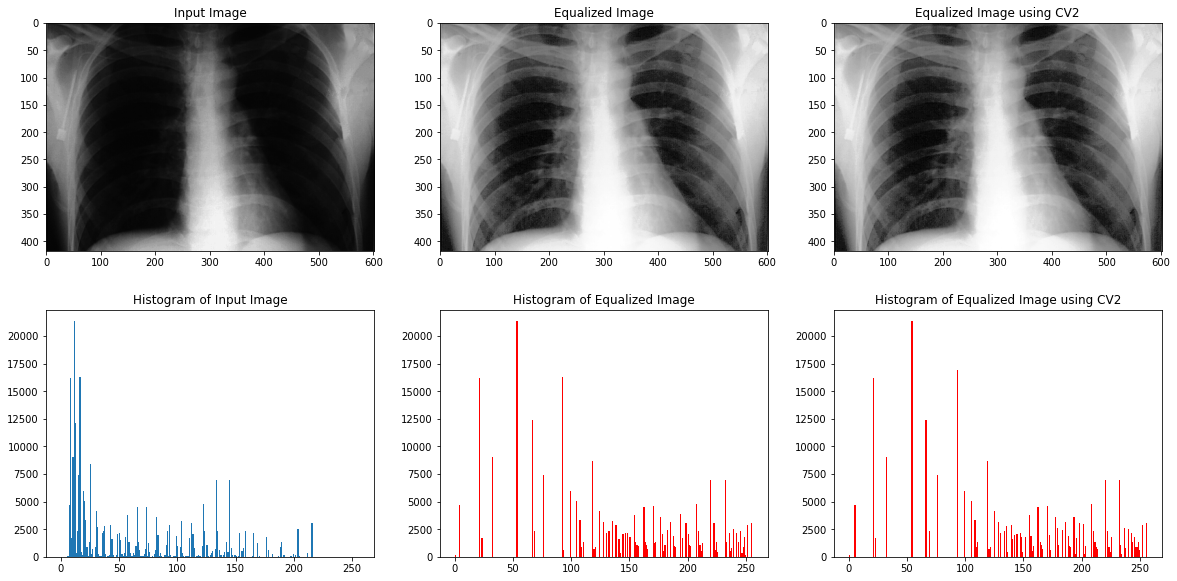

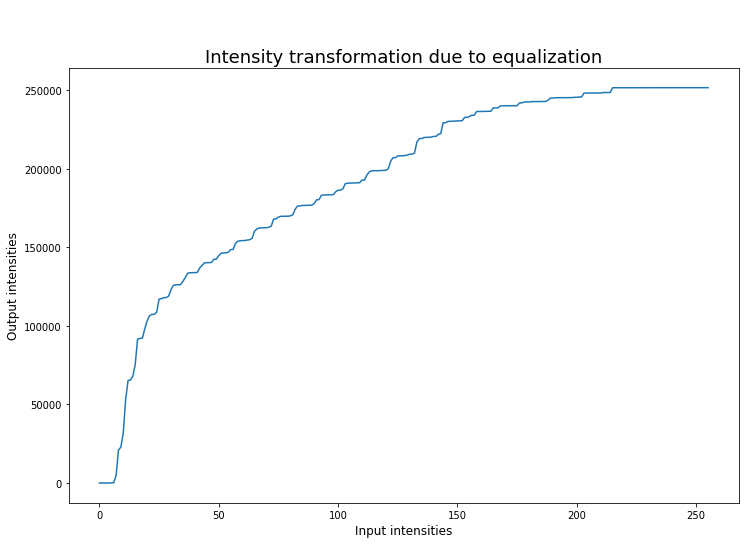

In [257]:
hist_eq(img1_gray)

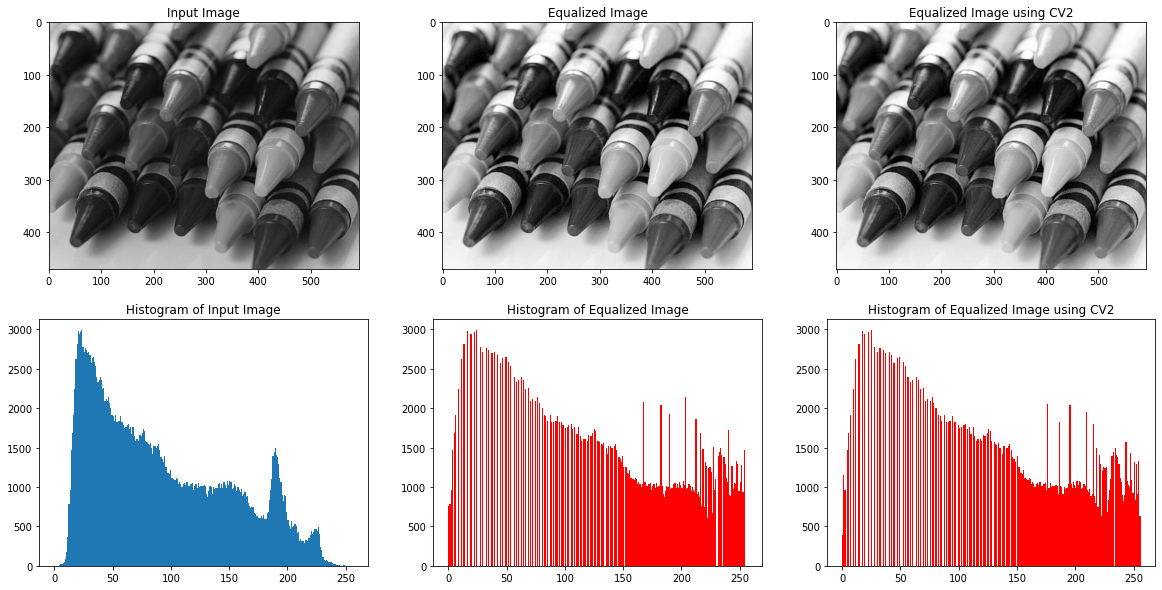

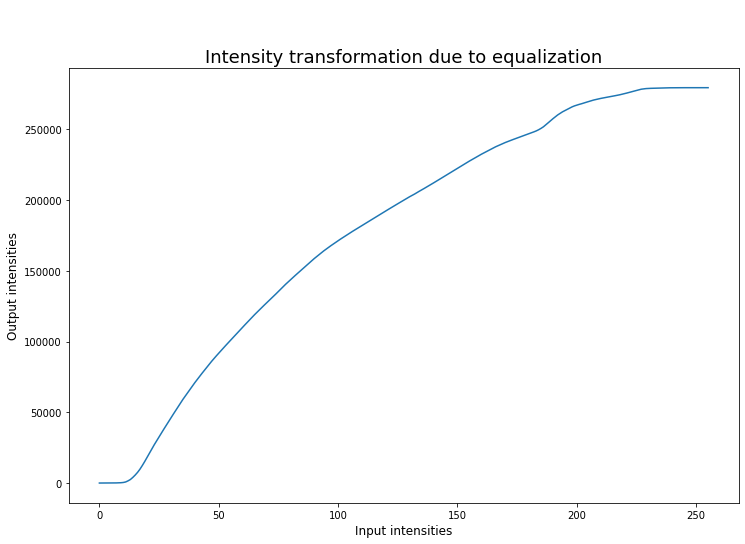

In [258]:
hist_eq(img2_gray)

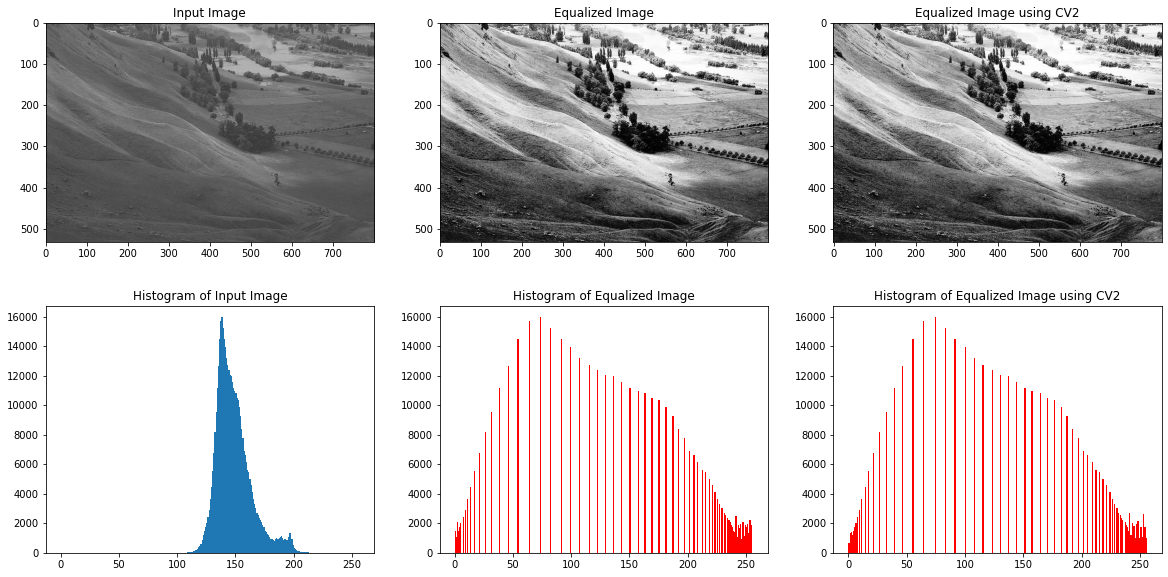

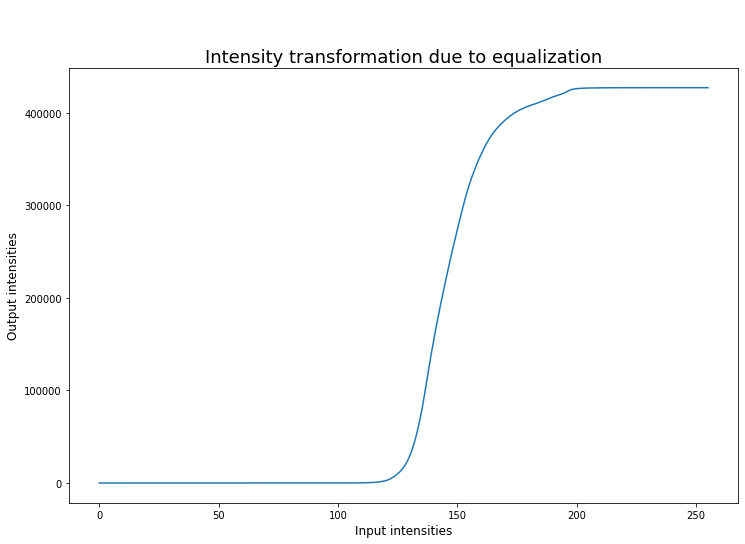

In [259]:
hist_eq(img3_gray)

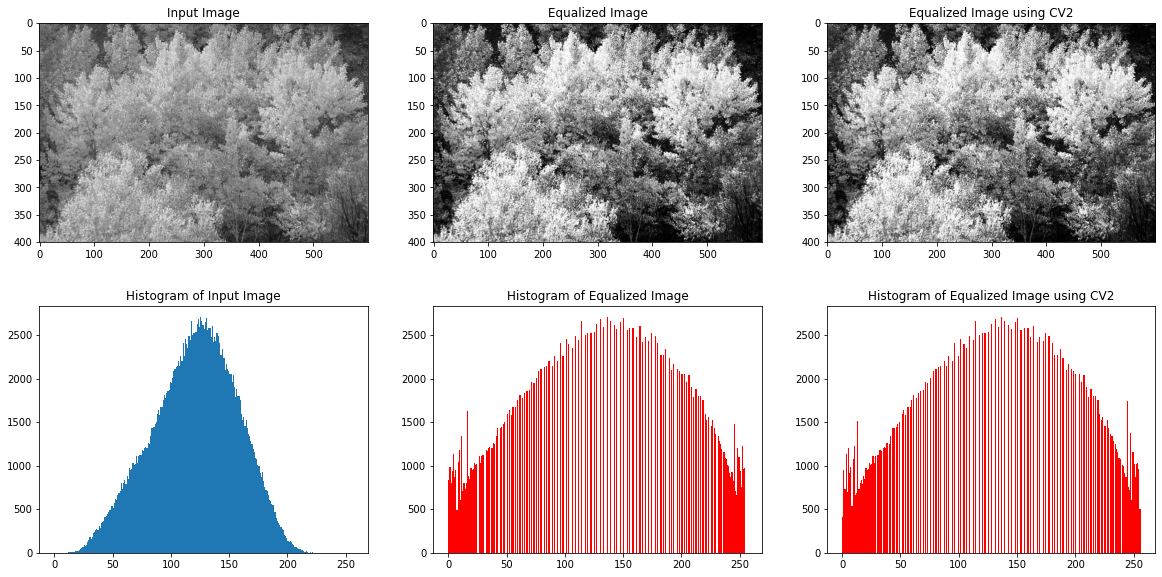

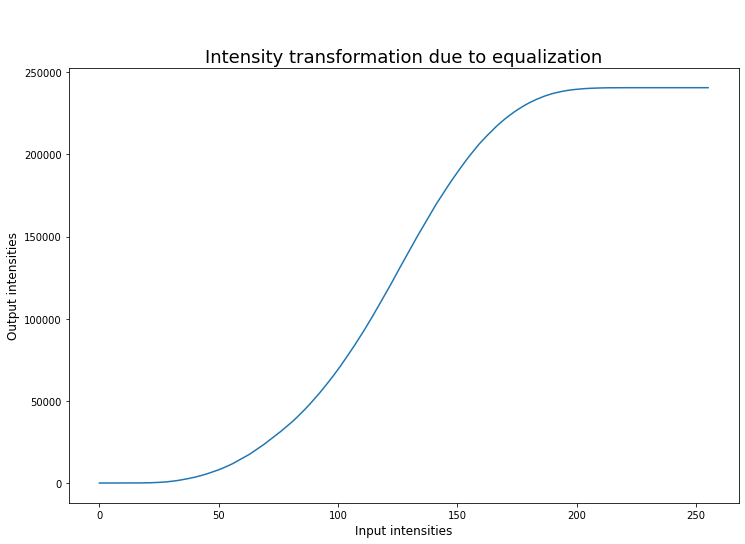

In [260]:
hist_eq(img4_gray)

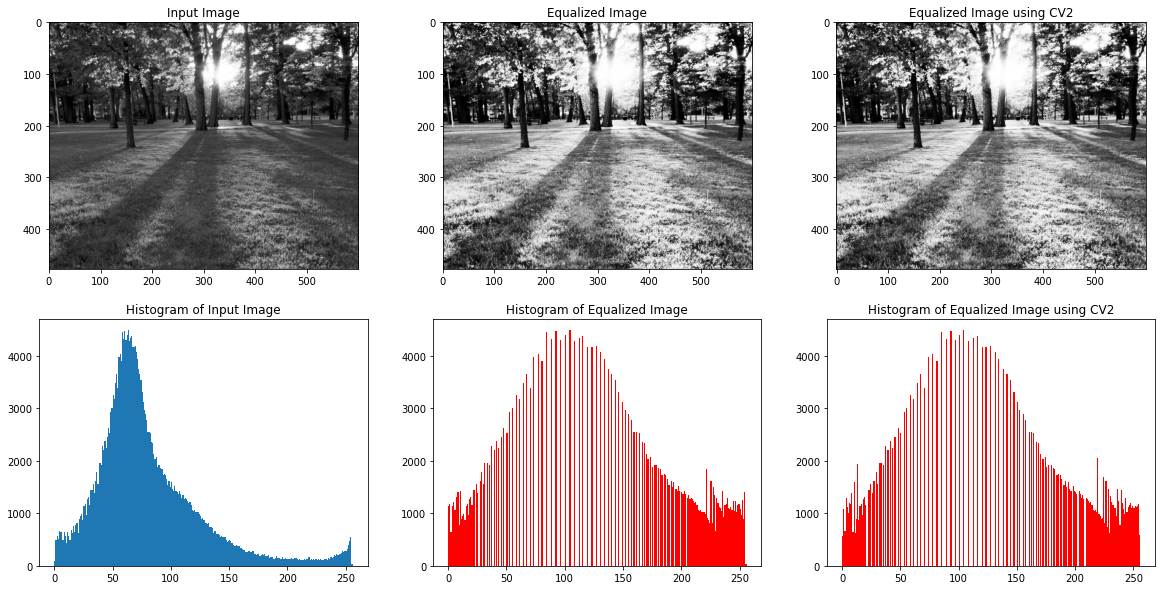

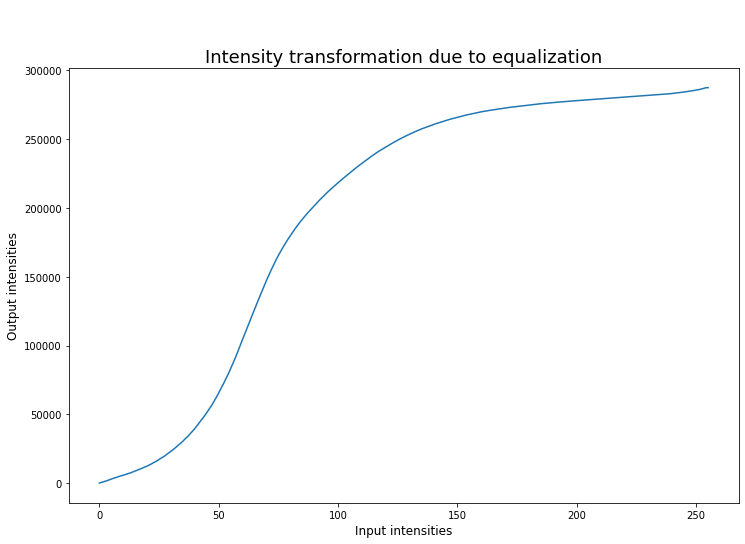

In [261]:
hist_eq(img5_gray)

The equalised histogram more or less follows a uniform distribution.

## Q3

In [262]:
def plot_hist_3chan(image):
  
  # Extracting channels
  channels = cv2.split(image)
  color = ['b', 'g', 'r']
  # Generating histograms
  fig, ax = plt.subplots(1,3, figsize=(15,5))
  for i in range(3):
    ax[i].hist(channels[i].flatten(), color=color[i])
    ax[i].set_title(f'Channel-{color[i]} Histogram')
  plt.suptitle(f"3 channel Histograms For Image  \n\n", fontsize=18)
  plt.show()

### 3 channel histogram split for "Image1"

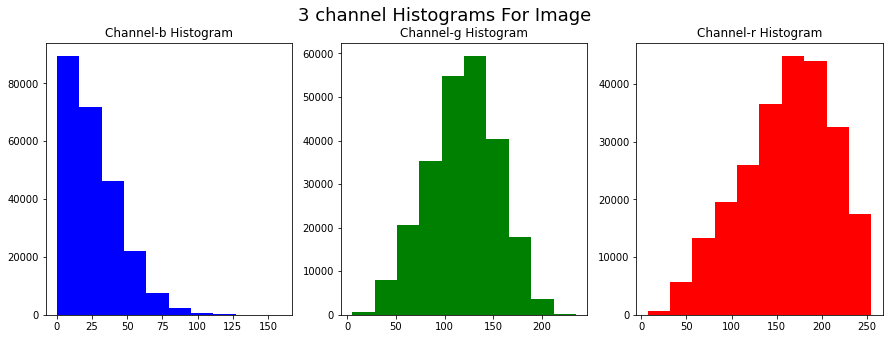

In [263]:
plot_hist_3chan(img4)

### 3 channel histogram split for "Image2"

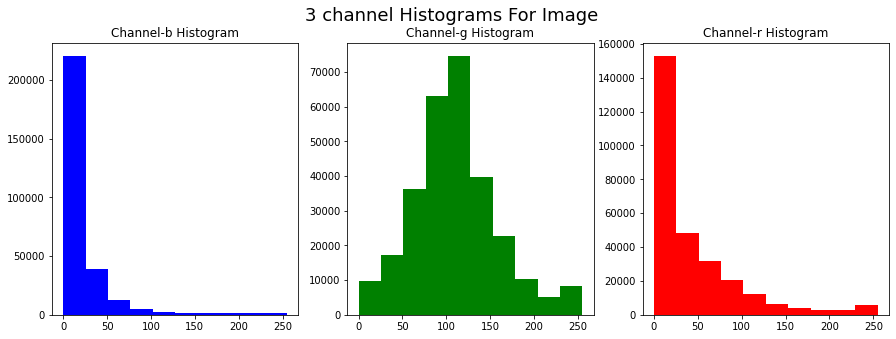

In [264]:
plot_hist_3chan(img5)

### Histogram Matching

In [265]:
def find_nearest_above(img, ref):
    diff = img - ref
    mask = np.ma.less_equal(diff, -1)
    if np.all(mask):
      return np.abs(diff).argmin()
    masked_diff = np.ma.masked_array(diff, mask)
    return masked_diff.argmin()

In [266]:
def match_hist(img, ref):
    oldshape = img.shape
    img = img.ravel()
    ref = ref.ravel()
    s_values, bin_idx, s_counts = np.unique(img,return_inverse=True,return_counts=True)
    t_values, t_counts = np.unique(ref, return_counts=True)
 
    # Calculate s_k for original image
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    # Calculate s_k for specified image
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
 
    # Round the values
    sour = np.around(s_quantiles*255)
    temp = np.around(t_quantiles*255)
       
    # Map the rounded values
    b=[]
    for data in sour[:]:
        b.append(find_nearest_above(temp,data))
    b= np.array(b,dtype='uint8')
 
    return b[bin_idx].reshape(oldshape)

In [267]:
def histogram_matching(img1, img2):

  # Splitting channels from both images
  b_src, g_src, r_src = cv2.split(img1)
  b_dst, g_dst, r_dst = cv2.split(img2)

  # Applying histogram matching to all pairs
  b_new = match_hist(b_src,b_dst)
  g_new = match_hist(g_src,g_dst)
  r_new = match_hist(r_src,r_dst)

  return b_new,g_new,r_new

In [268]:
blue,green,red=histogram_matching(img4_rgb,img5_rgb)

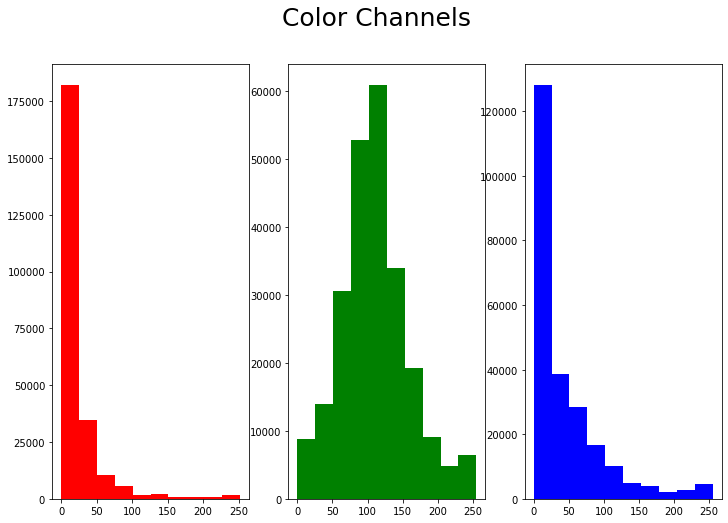

In [269]:
fig=plt.figure()

fig.add_subplot(1, 3, 1)
plt.hist(red.flatten(),color='r')
fig.add_subplot(1,3,2)
plt.hist(green.flatten(),color='g')
fig.add_subplot(1,3,3)
plt.hist(blue.flatten(),color='b')
fig.suptitle("Color Channels", fontsize=25)
plt.show()

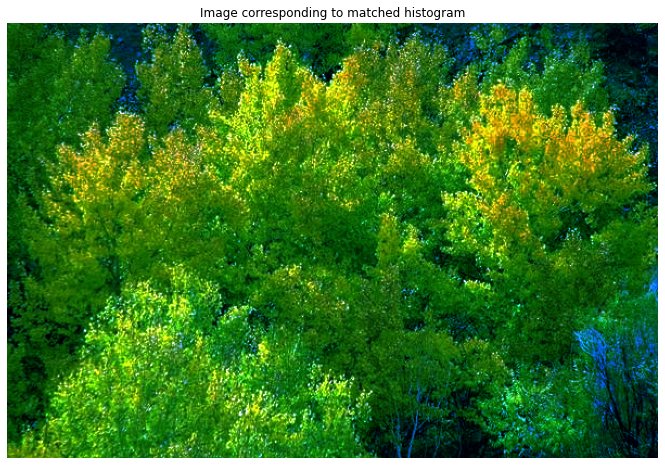

In [270]:
merged=cv2.merge([blue,green,red])
plt.imshow(merged)
plt.title("Image corresponding to matched histogram")
plt.axis('off')
plt.show()

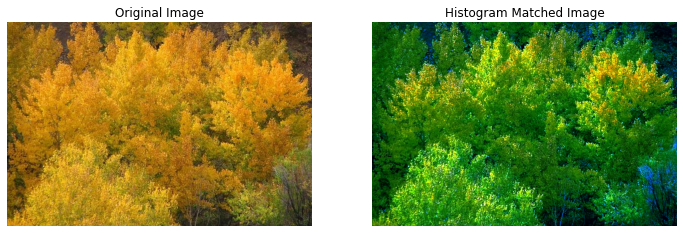

In [271]:
fig=plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(img4_rgb)
plt.title('Original Image')
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(merged)
plt.title("Histogram Matched Image")
plt.axis('off')
plt.show()

## Q5

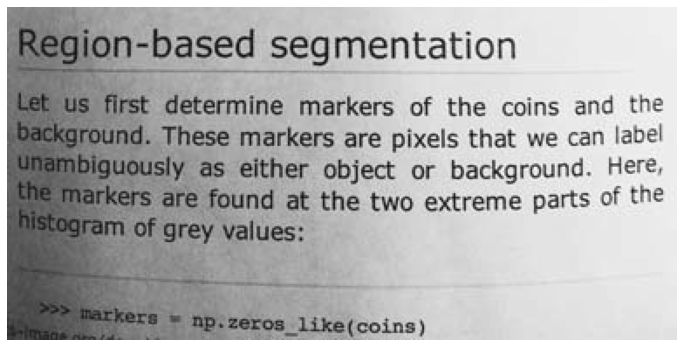

In [272]:
img1=data.page()
plt.imshow(img1,cmap="gray")
plt.axis('off')
plt.show()

In [273]:
low = 10
high= 100

In [274]:
def intensity_slicing_1(img):
  intensity=list(range(0,256))
  row, column = img.shape
  new_img = np.zeros((row,column),dtype = 'uint8')
  for i in range(row):
    for j in range(column):
        if img[i, j] > low and img[i, j] < high:
            new_img[i, j] = 255

  for i in range(256):
    if intensity[i]>low and intensity[i]<high:
      intensity[i]=255
    else:
      intensity[i]=0

  fig=plt.figure()

  fig.add_subplot(1, 2, 1)
  plt.imshow(new_img,cmap="gray")
  plt.title('Highlighting a particular range and rest 0')

  fig.add_subplot(1,2,2)
  plt.plot(list(range(0,256)),intensity,color='r')
  plt.xlim(0,255)
  plt.ylim(0,255)
  plt.show()
  return new_img

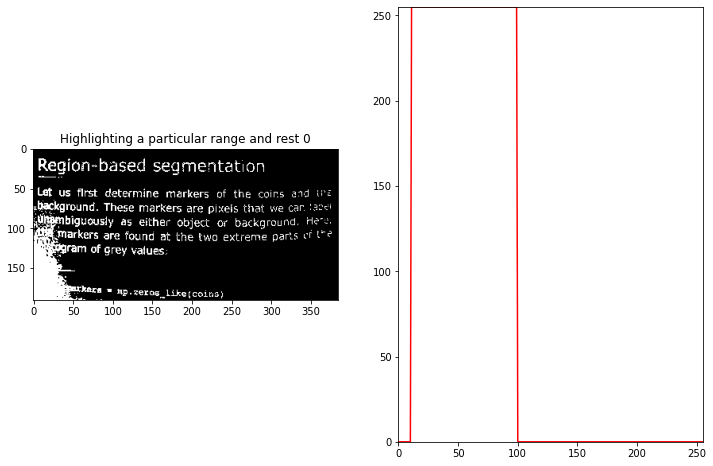

In [275]:
new1 = intensity_slicing_1(img1)

In [276]:
def intensity_slicing_2(img):
  intensity=list(range(0,256))
  row, column = img.shape
  new_img = np.zeros((row,column),dtype = 'uint8')
  for i in range(row):
    for j in range(column):
        if img[i, j] > low and img[i, j] < high:
            new_img[i, j] = 255
        else:
          new_img[i, j] = img[i, j]

  for i in range(256):
    if intensity[i]>low and intensity[i]<high:
      intensity[i]=255
    else:
      intensity[i]=i

  fig=plt.figure()

  fig.add_subplot(1, 2, 1)
  plt.imshow(new_img,cmap="gray")
  plt.title('Highlighting a particular range and rest unchanged')

  fig.add_subplot(1,2,2)
  plt.plot(list(range(0,256)),intensity,color='r')
  plt.xlim(0,255)
  plt.ylim(0,255)
  plt.show()
  return new_img

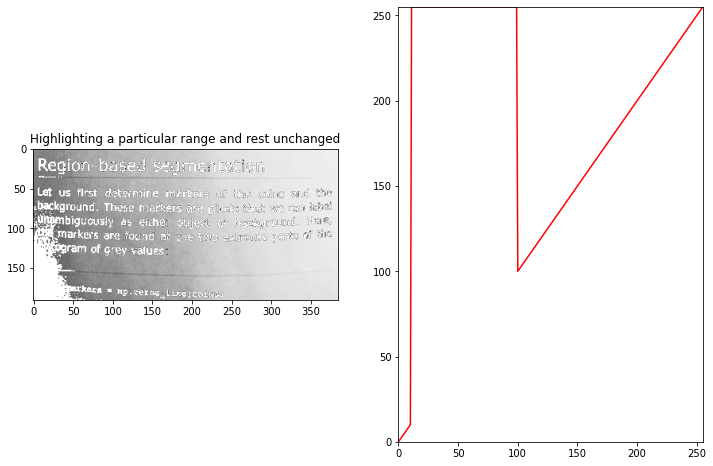

In [277]:
new2=intensity_slicing_2(img1)

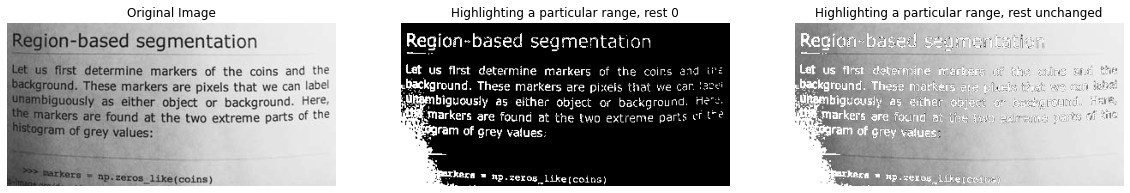

In [278]:
fig=plt.figure(figsize=(20,20))
fig.add_subplot(1, 3, 1)
plt.imshow(img1,cmap="gray")
plt.title("Original Image")
plt.axis('off')
fig.add_subplot(1, 3, 2)
plt.imshow(new1,cmap="gray")
plt.title("Highlighting a particular range, rest 0")
plt.axis('off')
fig.add_subplot(1, 3, 3)
plt.imshow(new2,cmap="gray")
plt.title("Highlighting a particular range, rest unchanged")
plt.axis('off')
plt.show()

## Q6

In [279]:
img1=data.page()
r,c=img1.shape

In [280]:
bitplanes = {}
for i in range(8):
    plane = np.full((r, c), 2**i, np.uint8)
    res = cv2.bitwise_and(plane, img1)
    bitplanes[i] = res

In [281]:
def plot_bitplane(bit):
  images=[]
  fig=plt.figure()
  for i in range(8):
    images.append(bit[i])
    fig.add_subplot(2,4,i+1)  
    plt.imshow(images[i],cmap="gray")
    plt.axis('off')
    plt.title('Bitplane'+str(i))

  plt.show()

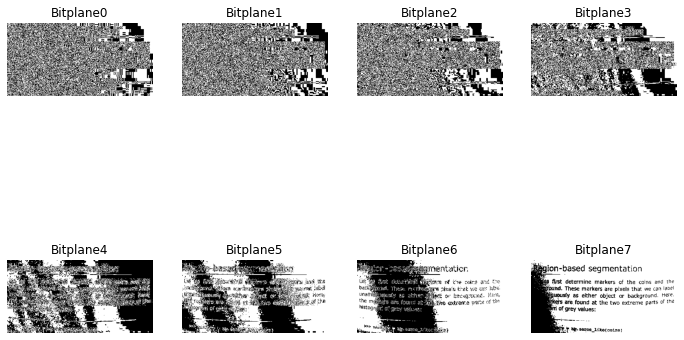

In [282]:
plot_bitplane(bitplanes)

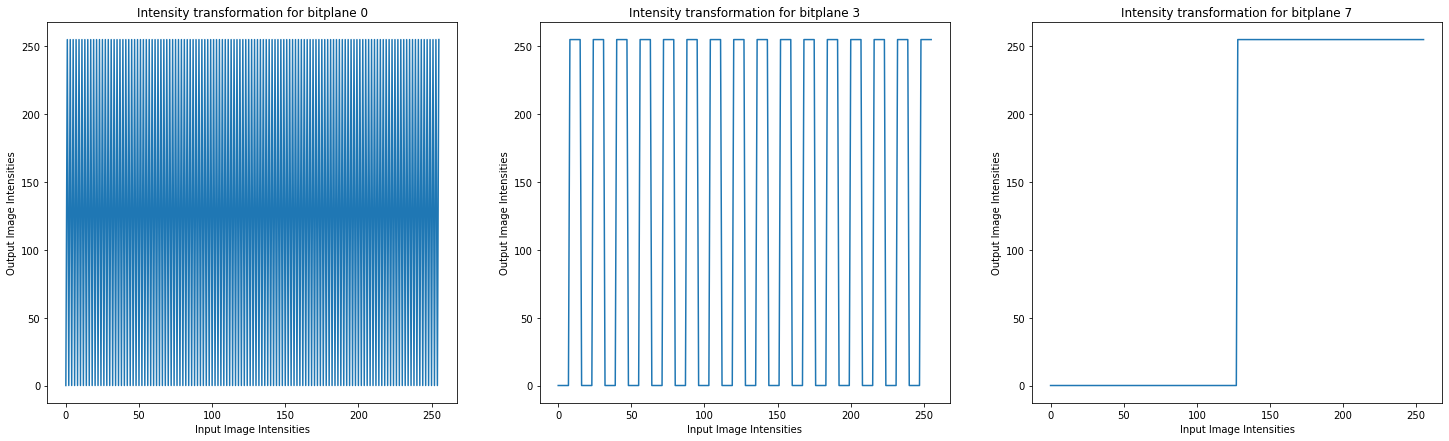

In [283]:
plane = [0,3,7]

fig=plt.figure(figsize=(25,7))
ax = 1
for i in plane:
    new = [0]*256
    for j in range(256):
        bit = np.binary_repr(j,width=8)
        if int(bit[7-i]) == 1:
            new[j] = 255
    
    fig.add_subplot(1, 3, ax)  
    plt.plot(list(range(0,256)),new)
    plt.xlabel("Input Image Intensities")
    plt.ylabel("Output Image Intensities")
    plt.title("Intensity transformation for bitplane " +str(i))
    ax+=1

plt.show()

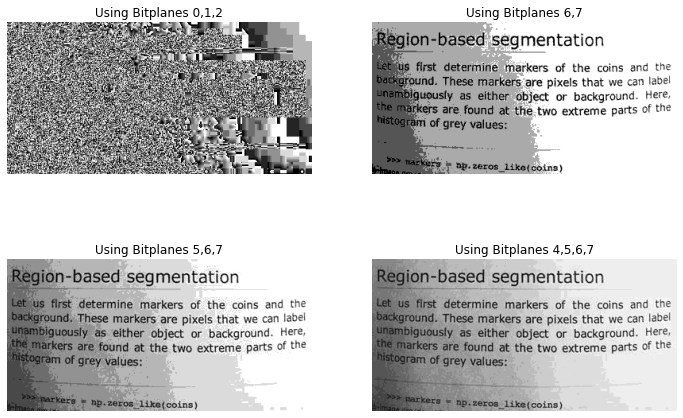

In [284]:
fig=plt.figure()

reconstructed_img1 = bitplanes[0]+bitplanes[1] + bitplanes[2]
reconstructed_img2 = bitplanes[6] + bitplanes[7]
reconstructed_img3 = bitplanes[5] + bitplanes[6] + bitplanes[7]
reconstructed_img4 = bitplanes[4] + bitplanes[5] + bitplanes[6] + bitplanes[7]

fig.add_subplot(2,2,1)  
plt.imshow(reconstructed_img1,cmap = 'gray')
plt.title('Using Bitplanes 0,1,2')
plt.axis('off')

fig.add_subplot(2,2,2)  
plt.imshow(reconstructed_img2,cmap = 'gray')
plt.title('Using Bitplanes 6,7')
plt.axis('off')

fig.add_subplot(2,2,3)  
plt.imshow(reconstructed_img3,cmap = 'gray')
plt.title('Using Bitplanes 5,6,7')
plt.axis('off')

fig.add_subplot(2,2,4)  
plt.imshow(reconstructed_img4,cmap = 'gray')
plt.title('Using Bitplanes 4,5,6,7')
plt.axis('off')

plt.show()

As it can be seen, using 4 bitplanes the image can be reconstructed prominently, but using 3 bitplanes also gives decent results.